# Visualizing Video Embeddings with Feluda and t-SNE 
This notebook demonstrates how to use the [`feluda`](https://github.com/tattle-made/feluda) to extract video embeddings and visualize them using t-SNE, with thumbnails overlaid for each video. It includes:
- Setting up Feluda and its operators.
- Using video data from a subset of the [UCF101 video dataset](https://huggingface.co/datasets/sayakpaul/ucf101-subset) dataset. We are using this for demo, but can be replaced with any video dataset.
- Generating video embeddings using feluda CLIP [video operator](https://pypi.org/project/feluda-vid-vec-rep-clip/).
- Reducing embedding dimensions using t-SNE
- Visualizing the reduced embeddings with video thumbnails

[![GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tattle-made/feluda/blob/main/docs/examples/plot_tsne_videos.ipynb)  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tattle-made/feluda/blob/main/docs/examples/plot_tsne_videos.ipynb)

Install dependencies conditionally based on whether the notebook is running in Colab or locally.

In [ ]:
%%time
import sys

IN_COLAB = "google.colab" in sys.modules
print("Running Notebook in Google Colab" if IN_COLAB else "Running Notebook locally")

if IN_COLAB:
    # Since Google Colab has preinstalled libraries like tensorflow and numba, we create a folder called feluda_custom_venv and isolate the environment there.
    # This is done to avoid any conflicts with the preinstalled libraries.
    %pip install uv
    !mkdir -p /content/feluda_custom_venv
    !uv pip install --target=/content/feluda_custom_venv --prerelease allow feluda feluda-vid-vec-rep-clip feluda-dimension-reduction opencv-python matplotlib > /dev/null 2>&1

    sys.path.insert(0, "/content/feluda_custom_venv")
else:
    !uv pip install feluda feluda-vid-vec-rep-clip feluda-dimension-reduction opencv-python matplotlib > /dev/null 2>&1

Running Notebook locally
Using Python 3.10.12 environment at: /home/aatman/Aatman/Tattle/feluda/.venv
Audited 5 packages in 9ms
CPU times: user 5.31 ms, sys: 4.17 ms, total: 9.48 ms
Wall time: 132 ms


In [2]:
import os
import tarfile
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from huggingface_hub import hf_hub_download
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from tqdm.notebook import tqdm

from feluda.factory import VideoFactory

We'll use two operators for this example. One for extracting embeddings and other for dimension reduction.

In [ ]:
from feluda.operators import DimensionReduction, VidVecRep

vid_vec_operator = VidVecRep()
dim_red_operator = DimensionReduction(model_type="tsne")

t-SNE model successfully initialized


Data Preparation

In [5]:
# Download and extract the UCF101 subset dataset
def download_and_extract_dataset() -> str:
    """Download and extract the UCF101 subset dataset from Hugging Face"""
    if not os.path.exists("UCF101_subset"):
        file_path = hf_hub_download(
            repo_id="sayakpaul/ucf101-subset",
            filename="UCF101_subset.tar.gz",
            repo_type="dataset",
        )

        with tarfile.open(file_path) as t:
            t.extractall(".")

        return file_path
    return None


file_path = download_and_extract_dataset()
print(f"Dataset downloaded at {file_path}")

Dataset downloaded at /Users/omkarkabde/.cache/huggingface/hub/datasets--sayakpaul--ucf101-subset/snapshots/b9984b8d2a95e4a1879e1b071e9433858d0bc24a/UCF101_subset.tar.gz


/var/folders/4p/bw6h5x8x1nb_17vsgfc12dz00000gn/T/ipykernel_56034/3928610610.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(".")


In [6]:
# Create thumbnails directory
thumbnail_dir = Path("thumbnails")
thumbnail_dir.mkdir(exist_ok=True)

In [7]:
def get_video_thumbnail(video_path: str) -> str:
    """Extract and save thumbnail from video.

    Args:
        video_path: Path to the video file

    Returns:
        Path to the saved thumbnail image

    """
    thumbnail_path = thumbnail_dir / f"{Path(video_path).stem}_thumbnail.jpg"

    # Return existing thumbnail if available
    if thumbnail_path.exists():
        return str(thumbnail_path)

    # Read the first frame from video
    cap = cv2.VideoCapture(str(video_path))
    ret, frame = cap.read()
    cap.release()

    if ret:
        cv2.imwrite(str(thumbnail_path), frame)
        return str(thumbnail_path)
    return None

In [8]:
def get_all_video_paths(base_dir: str = "UCF101_subset") -> list[str]:
    """Get all video paths recursively from the dataset directory.

    Args:
        base_dir: Base directory containing videos

    Returns:
        List of video file paths

    """
    video_paths = [str(path) for path in Path(base_dir).rglob("*.avi")]
    return video_paths


# Get all video paths
video_paths = get_all_video_paths()
print(f"Found {len(video_paths)} videos to process")

Found 405 videos to process


Video Processing and Embedding Extraction

In [9]:
# Process videos and collect embeddings
def process_videos(video_paths: list[str]):
    """Process videos and extract embeddings using Feluda.

    Args:
        video_paths: List of paths to video files

    Returns:
        List of dictionaries containing video path, embedding, and thumbnail path

    """
    operator_parameters = []

    for video_path in tqdm(video_paths, desc="Processing videos"):
        try:
            # Get video thumbnail
            thumbnail_path = get_video_thumbnail(video_path)

            # Get video embedding
            video = VideoFactory.make_from_file_on_disk(video_path)
            embedding = vid_vec_operator.run(video)
            average_vector = next(embedding)

            operator_parameters.append(
                {
                    "payload": video_path,
                    "embedding": average_vector.get("vid_vec"),
                    "thumbnail_path": thumbnail_path,
                }
            )
        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            continue

    print(f"Successfully processed {len(operator_parameters)} videos")
    return operator_parameters

In [10]:
# Process videos and collect embeddings
operator_parameters = process_videos(video_paths)
print(f"Successfully processed {len(operator_parameters)} videos")

Processing videos:   0%|          | 0/405 [00:00<?, ?it/s]

Successfully processed 405 videos
Successfully processed 405 videos


Dimensionality Reduction and Visualization

In [ ]:
# Reduce dimensions using operator for plotting t-SNE embeddings
data = dim_red_operator.run(operator_parameters)

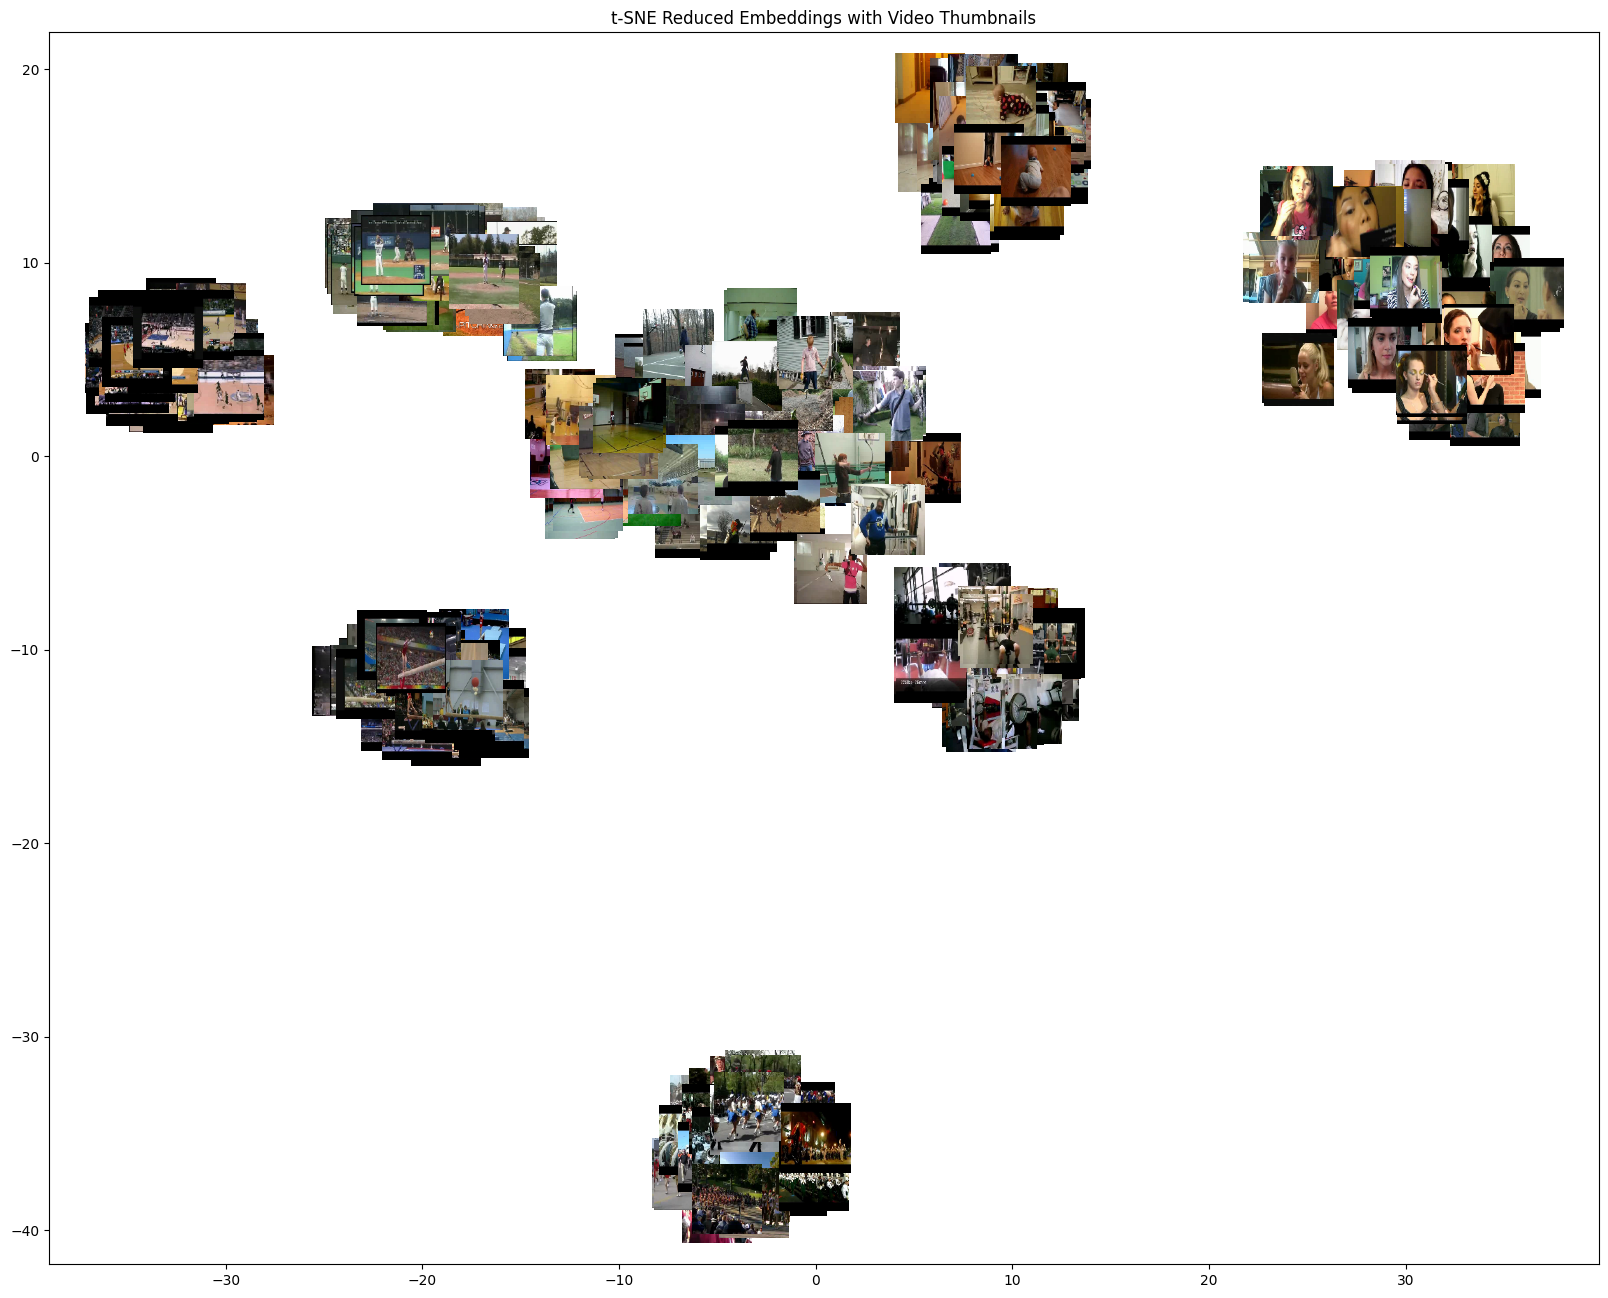

In [12]:
x = np.array([item["reduced_embedding"][0] for item in data])
y = np.array([item["reduced_embedding"][1] for item in data])


def jitter(arr, jitter_amount=0.02):
    return arr + np.random.uniform(-jitter_amount, jitter_amount, arr.shape)


x_jittered = jitter(x, jitter_amount=0.3)
y_jittered = jitter(y, jitter_amount=0.3)

plt.figure(figsize=(20, 16))
plt.scatter(x_jittered, y_jittered)


def load_thumbnail(payload):
    """Load the thumbnail from the pre-saved thumbnail folder."""
    video_filename = os.path.basename(payload)
    thumbnail_filename = video_filename.replace(".avi", "_thumbnail.jpg")
    thumbnail_path = os.path.join(thumbnail_dir, thumbnail_filename)

    if os.path.exists(thumbnail_path):
        return cv2.imread(thumbnail_path)
    else:
        print(f"Thumbnail not found for {video_filename}")
    return None


for i, item in enumerate(data):
    video_thumbnail = load_thumbnail(item["payload"])

    if video_thumbnail is not None:
        video_thumbnail = cv2.resize(video_thumbnail, (100, 100))  # Smaller thumbnails
        video_thumbnail = cv2.cvtColor(video_thumbnail, cv2.COLOR_BGR2RGB)

        # Keep zoom as is, no need for offsets anymore
        imagebox = OffsetImage(video_thumbnail, zoom=0.5)
        ab = AnnotationBbox(
            imagebox, (x_jittered[i], y_jittered[i]), frameon=False
        )  # Use jittered values

        plt.gca().add_artist(ab)

# Set labels and title
plt.title("t-SNE Reduced Embeddings with Video Thumbnails")
plt.show()

Cleanup

In [13]:
import shutil

shutil.rmtree("thumbnails")
shutil.rmtree("UCF101_subset")

dim_red_operator.cleanup()
vid_vec_operator.cleanup()